#Лабораторная работа №1: Классификация текста

Данный датасет представляет собой набор данных статей BBC, состоящий из двух столбцов, один с текстом, который должен быть классифицирован, и один с целевыми метками.

Импорт библиотек и загрузка датасета

In [36]:
# Импорт библиотек(Загружаются в том числе неисользуемые, тк были разные версии)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec, FastText
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.keras.optimizers import SGD, Adam
import kagglehub

path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
data = pd.read_csv(f"{path}/bbc_text_cls.csv")

print("Path to dataset files:", path)
print(data.head())

Path to dataset files: /root/.cache/kagglehub/datasets/jacopoferretti/bbc-articles-dataset/versions/1
                                                text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business


Датасет содержит две колонки: text и labels. Первая колонка содержит текстовые статьи, а вторая — их соответствующие категории, такие как "business".

#1. EDA - анализа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64
Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None

Статистики по меткам:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


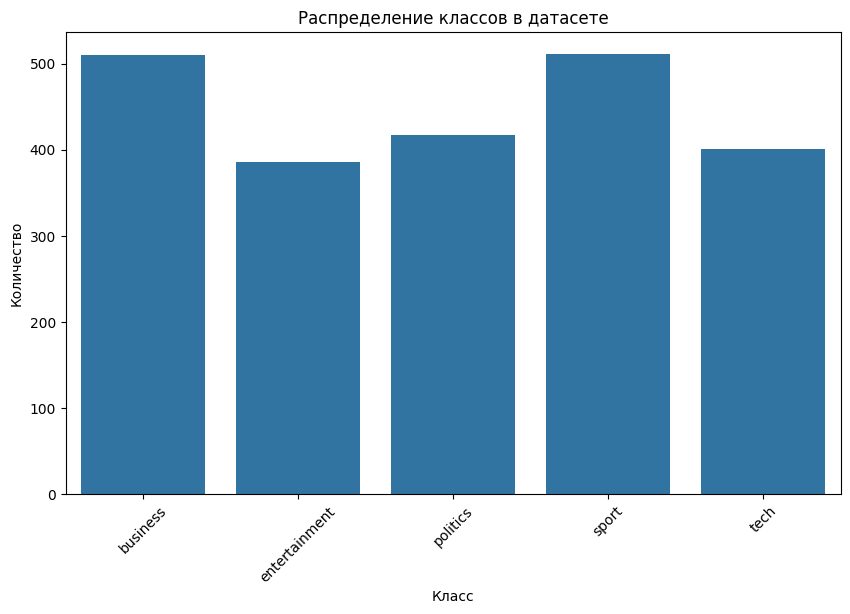

In [37]:
print(data.info())
print(data['labels'].value_counts())

print("Общая информация о данных:")
print(data.info())

print("\nСтатистики по меткам:")
print(data['labels'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=data)
plt.title('Распределение классов в датасете')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Датасет состоит из 2225 записей, каждая из которых содержит текст статьи и соответствующую категорию. Распределение классов показало, что категории достаточно сбалансированы: "sport" и "business" имеют около 511 и 510 записей соответственно, тогда как "politics", "tech" и "entertainment" имеют 417, 401 и 386 записи.

In [38]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

print("\nОчищенные строки:")
print(data[['text', 'cleaned_text']].head())


Очищенные строки:
                                                text  \
0  Ad sales boost Time Warner profit\n\nQuarterly...   
1  Dollar gains on Greenspan speech\n\nThe dollar...   
2  Yukos unit buyer faces loan claim\n\nThe owner...   
3  High fuel prices hit BA's profits\n\nBritish A...   
4  Pernod takeover talk lifts Domecq\n\nShares in...   

                                        cleaned_text  
0  ad sales boost time warner profit quarterly pr...  
1  dollar gains on greenspan speech the dollar ha...  
2  yukos unit buyer faces loan claim the owners o...  
3  high fuel prices hit bas profits british airwa...  
4  pernod takeover talk lifts domecq shares in uk...  


Процесс очистки текста состоял в преобразовании всех символов в нижний регистр, удалении лишних пробелов, цифр и знаков препинания. В результате мы получили более чистые и стандартизированные строки текста, которые облегчат дальнейшую обработку.

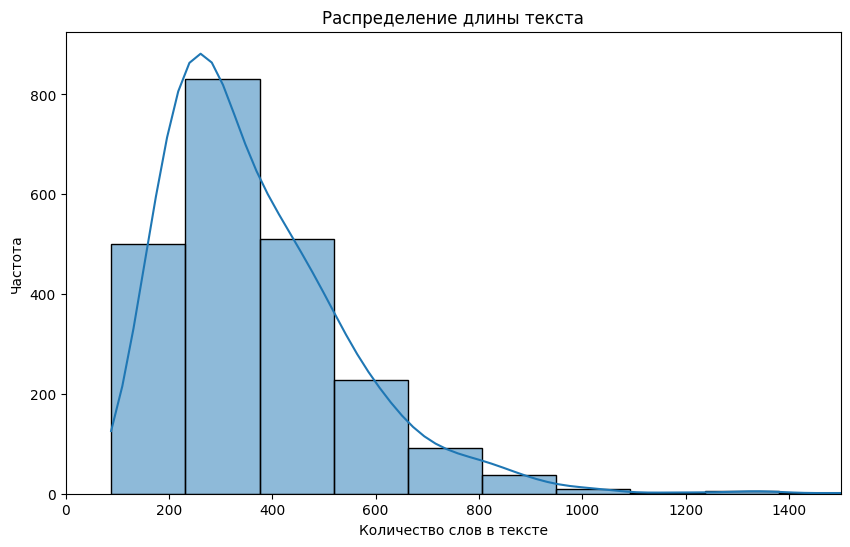

In [39]:
data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data['num_words'] = data['cleaned_text'].apply(lambda x: len(re.findall(r'\w+', x)))
data['unique_word_ratio'] = data['num_words'] / data['text_length']

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Распределение длины текста')
plt.xlabel('Количество слов в тексте')
plt.ylabel('Частота')
plt.xlim(0, 1500)
plt.show()

График показывает, что большинство текстов в датасете имеют длину от 100 до 500 слов.

<ipython-input-40-283a80b890e8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


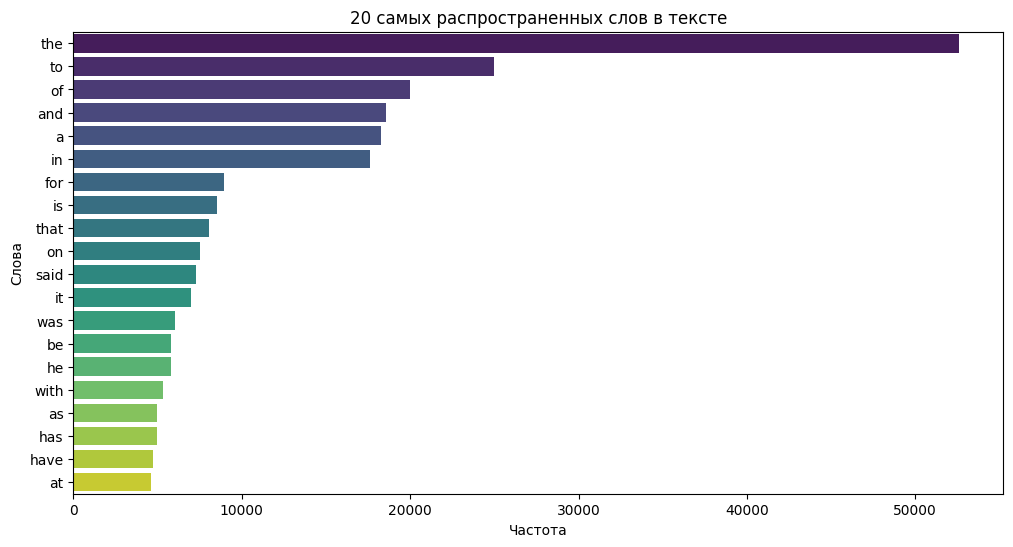

In [40]:
all_words = ' '.join(data['cleaned_text']).split()
word_counts = Counter(all_words)

most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 самых распространенных слов в тексте')
plt.xlabel('Частота')
plt.ylabel('Слова')
plt.show()

Таким образом, мы получили график самых распостранённых слов в тексте. И сделаем такой же график, только для уникальных слов.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-41-b3d71bb722e0>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


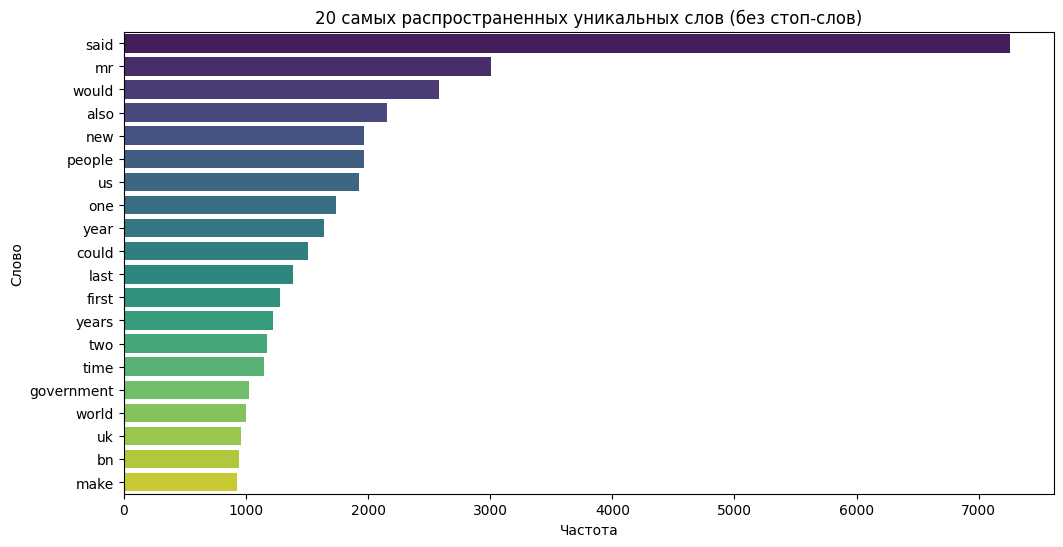

In [41]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_words = [
    word for text in data['cleaned_text'] for word in text.split() if word not in stop_words
]

word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 самых распространенных уникальных слов (без стоп-слов)')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.show()

График показывает самые распостранённые "уникальные" слова, что должно помочь с определением содержания статей...

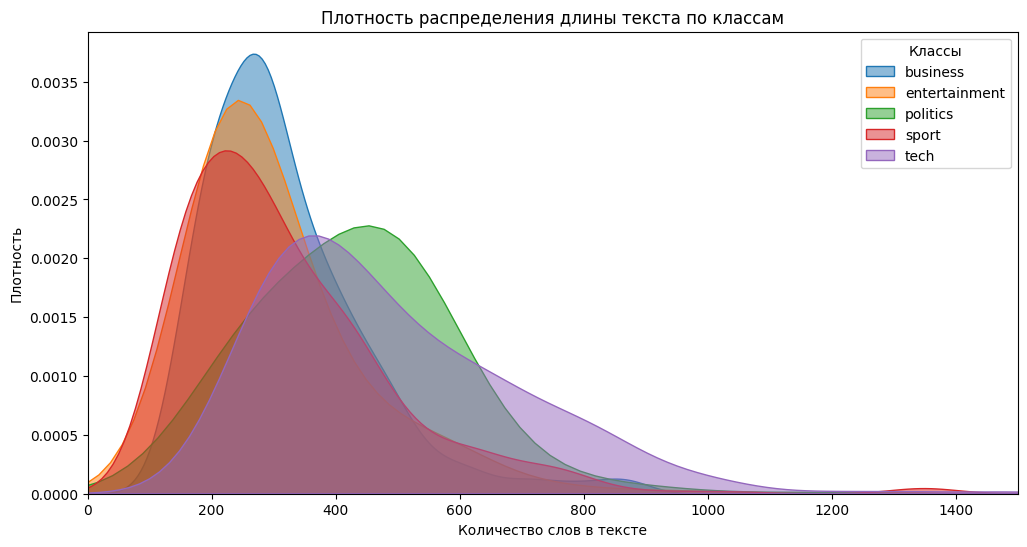

In [42]:
plt.figure(figsize=(12, 6))
for label in data['labels'].unique():
    sns.kdeplot(data[data['labels'] == label]['text_length'], label=label, fill=True, alpha=0.5)

plt.title('Плотность распределения длины текста по классам')
plt.xlabel('Количество слов в тексте')
plt.ylabel('Плотность')
plt.legend(title='Классы')
plt.xlim(0, 1500)
plt.show()

Получается тексты в категории "buisness", "entertainment", "sport" имеют примерно схожую длину текстов и с большей вероятностью находятся в интервале 150-400 слов, а категории "politics" и "tech" в интервале 300-600.

# 2. Embeddings

In [43]:
one_hot = pd.get_dummies(data['labels'])

tokenized_texts = [text.split() for text in data['cleaned_text']]
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

fasttext_model = FastText(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['cleaned_text']).toarray()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['labels'])

Создание эмбеддингов с использованием Word2Vec, FastText и TF-IDF, а также преобразование метки в числовые значения для дальнейшего обучения модели.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

 Данные были разделены на обучающую и тестовую выборки, что позволяет оценить производительность модели на независимых данных.

# 3. ML-algorithms

In [45]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
log_reg_accuracy = log_reg.score(X_test, y_test)
print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")

Точность логистической регрессии: 0.9663


Модель логистической регрессии имеет выоскую точность 96.63% на тестовой выборке. Это указывает на то, что модель эффективно классифицирует тексты из данного датасета, что может свидетельствовать о хорошей разделимости классов и качественной предобработке данных.

In [46]:
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность логистической регрессии с кросс-валидацией: {log_reg_scores.mean():.4f}")

Средняя точность логистической регрессии с кросс-валидацией: 0.9770


Логистическая регрессия с кросс-валидацией показывает более высокую среднюю точность(97.70%).

In [47]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_accuracy = nb_classifier.score(X_test, y_test)
print(f"Точность наивного байесовского классификатора: {nb_accuracy:.4f}")

Точность наивного байесовского классификатора: 0.9573


  Наивный байесовский классификатор получил точность 95.73%, что немного ниже, чем точность логистической регрессии.

In [48]:
nb_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность наивного байесовского классификатора с кросс-валидацией: {nb_scores.mean():.4f}")

Средняя точность наивного байесовского классификатора с кросс-валидацией: 0.9719


Наивный байесовский классификатор с кросс-валидацией показал среднюю точность 97.19%, что выше, чем его первоначальная точность (95.73%). Это свидетельствует о том, что кросс-валидация помогает лучше оценить модель. Но логистическая регрессия с кросс-валидацией немного превосходит наивный байесовский классификатор с кросс-валидацией.

In [49]:
param_grid_log_reg = {'C': [0.1, 1, 10, 100]}
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')
grid_log_reg.fit(X_train, y_train)
print("Лучшие параметры для логистической регрессии:", grid_log_reg.best_params_)
print("Лучшая точность логистической регрессии на CV:", grid_log_reg.best_score_)

Лучшие параметры для логистической регрессии: {'C': 100}
Лучшая точность логистической регрессии на CV: 0.9814606741573033


Результаты GridSearch показали, что оптимальное значение гиперпараметра C для логистической регрессии равно 100. Лучшая точность, достигнутая с использованием кросс-валидации, составляет 98.15%. Это на 0.45% выше, чем средняя точность логистической регрессии без подбора гиперпараметров (97.70%). Таким образом, использование GridSearch для подбора гиперпараметров позволяет значительно улучшить качество модели.

In [50]:
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 5.0]}
grid_nb = GridSearchCV(nb_classifier, param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(X_train, y_train)
print("Лучшие параметры для наивного Байеса:", grid_nb.best_params_)
print("Лучшая точность наивного Байеса на CV:", grid_nb.best_score_)

Лучшие параметры для наивного Байеса: {'alpha': 0.1}
Лучшая точность наивного Байеса на CV: 0.9792134831460674


Результаты GridSearch показали, что оптимальное значение гиперпараметра alpha для наивного байесовского классификатора равно 0.1. Точность(97.92%) указывает на высокую эффективность модели. Это также выше, чем наивный байесовский классификатор без GridSearch(97.19%).

Таким образом, логистическая регрессия показала более высокие результаты по сравнению с наивным байесовским классификатором как в обычных условиях, так и при кросс-валидации. Оптимизация гиперпараметров для обеих моделей продемонстрировала значительное улучшение их производительности.

# 4. Нейронная сеть

In [51]:
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [52]:
model = create_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Точность нейронной сети: {accuracy:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3794 - loss: 1.5647 - val_accuracy: 0.8371 - val_loss: 1.1658
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7906 - loss: 0.9993 - val_accuracy: 0.9663 - val_loss: 0.3746
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9494 - loss: 0.3407 - val_accuracy: 0.9747 - val_loss: 0.1463
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9854 - loss: 0.1437 - val_accuracy: 0.9860 - val_loss: 0.0792
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9907 - loss: 0.0820 - val_accuracy: 0.9803 - val_loss: 0.0604
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9906 - loss: 0.0543 - val_accuracy: 0.9831 - val_loss: 0.0497
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0347 - val_accuracy: 0.9860 - val_loss: 0.0425
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9983 - loss: 0.0263 - val_accuracy: 0.9860 - val_loss: 0.

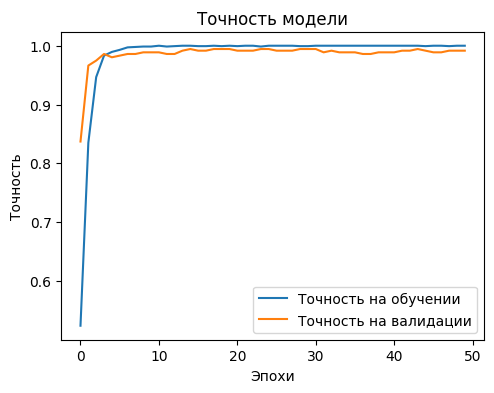

In [53]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность модели')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.show()

Таким образом, была реализована полносвязанная нейронная сеть и модель продемонстрировала высокую точность на тестовых данных, что указывает на ее способность эффективно классифицировать текстовые данные по заданным категориям (sport, business, politics, tech и entertainment). А использование регуляризации (Dropout) и оптимизатора Adam способствовало уменьшению переобучения и обеспечению хорошей обобщающей способности модели.